In [1]:
import jax
from typing import Any, Callable, Sequence
from jax import random, numpy as jnp
import flax
from flax import linen as nn
import optax

In [15]:
A = jnp.arange(100).reshape(20, 5)
idxs = jax.random.randint(random.PRNGKey(0), (10,), 0, 5)

# print(A)
# print(idxs)
print(A)
print(idxs)
print(A[jnp.arange(10), idxs])

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]
 [30 31 32 33 34]
 [35 36 37 38 39]
 [40 41 42 43 44]
 [45 46 47 48 49]
 [50 51 52 53 54]
 [55 56 57 58 59]
 [60 61 62 63 64]
 [65 66 67 68 69]
 [70 71 72 73 74]
 [75 76 77 78 79]
 [80 81 82 83 84]
 [85 86 87 88 89]
 [90 91 92 93 94]
 [95 96 97 98 99]]
[3 0 2 1 2 3 0 1 2 2]
[ 3  5 12 16 22 28 30 36 42 47]


In [ ]:
done = jnp.array([True, False,  True, False, True], dtype=bool)
obs = jnp.array([[ 0.5162862 ,  0.2074894 ,  0.7240187 , -1.0787021 ,  0.04069785,
                 -0.06364991,  1.        ,  0.        ],
                [ 0.11500321,  1.1899251 ,  0.50547856, -0.419965  , -0.2609647 ,
                 -0.33009827,  0.        ,  0.        ],
                [-0.63004315, -0.23130883, -0.3797977 , -0.47536182,  2.8034565 ,
                  1.9403803 ,  0.        ,  0.        ],
                [-0.153934  ,  1.1053196 , -0.3867789 , -0.58739966,  0.3082726 ,
                  0.06706445,  0.        ,  0.        ],
                [-0.0033843 ,  1.4856167 ,  0.04007225,  0.00840264, -0.11051258,
                 -0.24021249,  0.        ,  0.        ]], dtype=jnp.float32)

print(done.shape)
print(obs.shape)

In [ ]:
def classify_goal(x):
    result = jnp.zeros_like(x, dtype=jnp.int32)
    result = result.at[x < -0.33].set(0)
    result = result.at[(x >= -0.33) & (x < 0.33)].set(1)
    result = result.at[x >= 0.33].set(2)

    return result

done_idx = jnp.argwhere(done).reshape(-1)
goal_idx = classify_goal(obs[done_idx, 0])

print(done_idx)
print(obs[done_idx, 0])
print(goal_idx)

In [2]:
from craftax_classic.envs.craftax_symbolic_env import CraftaxClassicSymbolicEnv
from environment_base.wrappers import AutoResetEnvWrapper, BatchEnvWrapper

rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
rngs = jax.random.split(_rng, 3)

# Create environment
env = AutoResetEnvWrapper(CraftaxClassicSymbolicEnv())
env_params = env.default_params

# Get an initial state and observation
obs, state = env.reset(rngs[0], env_params)

# Pick random action
action = env.action_space(env_params).sample(rngs[1])

# Step environment
obs, state, reward, done, info = env.step(rngs[2], state, action, env_params)

# print(all_map.flatten().shape)
# print(inventory.shape)
# print(intrinsics.shape)
# print(direction.shape)
# print(jnp.array([state.light_level, state.is_sleeping]).shape)

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8500
The local installation version must be no lower than 8900. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/nas/ucb/arvindrajaraman/anaconda3/envs/diayn/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


In [3]:
reward

Array(0., dtype=float32)

In [ ]:
# Load iris dataset from sklearn
from sklearn.datasets import load_iris
iris = load_iris()

# Extract features and labels
X = iris.data
y = iris.target

# Convert X and y into jnp arrays
X = jnp.array(X)
y = jnp.array(y)

# Convert y into one hot
y = jnp.eye(3)[y]

print(X.shape, y.shape)

In [ ]:
class MLP(nn.Module):
    hidden1_size: int
    hidden2_size: int
    hidden3_size: int
    output_size: int
    
    dropout_rate: float

    @nn.compact
    def __call__(self, x, train=False):
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not train)
        x = nn.Dense(features=self.hidden1_size)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not train)
        x = nn.Dense(features=self.hidden2_size)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not train)
        x = nn.Dense(features=self.hidden3_size)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.output_size)(x)
        x = nn.log_softmax(x)
        return x

In [ ]:
key = jax.random.PRNGKey(0)
input_shape = (768,)

model = MLP(hidden1_size=64, hidden2_size=64, hidden3_size=16, output_size=3, dropout_rate=0.2)
params = model.init(key, jnp.ones(input_shape, jnp.float32))

print(model)

In [ ]:
dummy_obs = jnp.ones((10, 1345))

blocks_labels = ['invalid', 'out of bounds', 'grass', 'water', 'stone', 'tree', 'wood', 'path', 'coal', 'iron', 'diamond', 'crafting table', 'furnace', 'sand', 'lava', 'plant', 'ripe plant']
mobs_labels = ['zombie', 'cow', 'skeleton', 'arrow']
inventory_labels = ['wood', 'stone', 'coal', 'iron', 'diamond', 'sapling', 'wood pickaxe', 'stone pickaxe', 'iron pickaxe', 'wood sword', 'stone sword', 'iron sword']

health_labels = ['very unhealthy', 'unhealthy', 'at okay health', 'healthy', 'very healthy']
food_labels = ['very hungry', 'hungry', 'at okay hunger', 'full', 'very full']
thirsty_labels = ['very thirsty', 'thirsty', 'at okay thirst', 'thirsty', 'very thirsty']
energy_labels = ['very tired', 'tired', 'at okay energy', 'well-rested', 'very well-rested']

def embedding_crafter(next_obs, _):
    batch_size = next_obs.shape[0]
    maps, metadata = jnp.split(next_obs, [7 * 9 * 21], axis=1)
    
    # For each block/mob type, count how many are in frame
    maps = jnp.reshape(maps, [-1, 7, 9, 21])
    maps = jnp.transpose(maps, [0, 3, 1, 2])
    maps = jnp.reshape(maps, [-1, 21, 7 * 9])
    maps = maps.sum(axis=2)
    maps = jnp.round(maps).astype(jnp.int32)
    blocks, mobs = jnp.split(maps, [17], axis=1)

    # Extract and format metadata
    inventory, intrinsics, direction, light_level, is_sleeping = jnp.split(metadata, [12, 16, 20, 21], axis=1)
    inventory = jnp.round(inventory * 10.0).astype(jnp.int32)
    intrinsics *= 10.0

    health, food, drink, energy = jnp.split(intrinsics, [1, 2, 3], axis=1)

    # Construct embedding
    for i in range(batch_size):
        blocks_gt0 = jnp.argwhere(blocks[i] > 0).reshape(-1)
        mobs_gt0 = jnp.argwhere(mobs[i] > 0).reshape(-1)
        inventory_gt0 = jnp.argwhere(inventory[i] > 0).reshape(-1)

        blocks_str = 'You see the following blocks: {}.'.format(', '.join([blocks_labels[b] for b in blocks_gt0]))
        mobs_str = 'You see the following mobs: {}.'.format(', '.join([mobs_labels[m] for m in mobs_gt0]))
        inventory_str = 'You have in your inventory: {}.'.format(', '.join([inventory_labels[i] for i in inventory_gt0]))

        health_str = 'Your health level is: {}.'.format(health_labels[round(health[i].item() / 2.0) - 1])
        food_str = 'Your hunger level is: {}.'.format(food_labels[round(food[i].item() / 2.0) - 1])
        drink_str = 'Your thirst level is: {}.'.format(thirsty_labels[round(drink[i].item() / 2.0) - 1])
        energy_str = 'Your energy level is: {}.'.format(energy_labels[round(energy[i].item() / 2.0) - 1])

        desc = [health_str, food_str, drink_str, energy_str]
        if len(blocks_gt0) > 0:
            desc.append(blocks_str)
        if len(mobs_gt0) > 0:
            desc.append(mobs_str)
        if len(inventory_gt0) > 0:
            desc.append(inventory_str)

        desc = ' '.join(desc)

    return intrinsics

embedding_crafter(dummy_obs, None)

In [ ]:
import jax.numpy as jnp

# Calculate mutual information given a normalized 3 x 3 matrix
def normalize_freq_matrix(freq_matrix):
    if jnp.sum(freq_matrix) < 1e-9:
        return jnp.zeros((3, 3))
    
    conf_matrix = freq_matrix / (jnp.sum(freq_matrix, axis=1, keepdims=True) + 1e-9)
    return conf_matrix

def I_zs_score(freq_matrix):
    freq_matrix = normalize_freq_matrix(freq_matrix)

    total_freq = jnp.sum(freq_matrix)
    if total_freq < 1e-9:
        return 0.0
    
    p_y = jnp.sum(freq_matrix, axis=0) / total_freq
    p_yhat = jnp.sum(freq_matrix, axis=1) / total_freq
    p_y_yhat = freq_matrix / total_freq
    
    mi = 0.0
    for i in range(3):
        for j in range(3):
            if p_y_yhat[i, j] > 0 and p_y[i] > 0 and p_yhat[j] > 0:
                mi += p_y_yhat[i, j] * jnp.log(p_y_yhat[i, j] / (p_y[i] * p_yhat[j] + 1e-9))

    return mi

# I_zs_score(jnp.array([[0.101, 0.781, 0.118],
#                       [0.055, 0.794, 0.151],
#                       [0.097, 0.767, 0.136]]))

I_zs_score(jnp.array([[0.0, 1.0, 0.0],
                      [1.0, 0.0, 0.0],
                      [0.0, 0.0, 1.0]]))

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8500
The local installation version must be no lower than 8900. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array(1.0986123, dtype=float32)

In [ ]:
class QNetCraftax(nn.Module):
    action_size: 17

    @nn.compact
    def __call__(self, x):
        maps, metadata = jnp.split(x, [7 * 9 * 21], axis=1)
        maps = maps.reshape((-1, 7, 9, 21))
        
        maps = nn.Conv(features=32, kernel_size=(3, 3), padding='SAME')(maps)
        maps = nn.relu(maps)
        maps = nn.max_pool(maps, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        maps = nn.Conv(features=64, kernel_size=(3, 3), padding='SAME')(maps)
        maps = nn.relu(maps)
        maps = nn.max_pool(maps, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        maps = maps.reshape((maps.shape[0], -1))

        y = jnp.concatenate((maps, metadata), axis=-1)
        y = nn.Dense(128)(y)
        y = nn.relu(y)
        y = nn.Dense(64)(y)
        y = nn.relu(y)
        y = nn.Dense(self.action_size)(y)
        y = nn.softmax(y)
        return y

In [ ]:
key = jax.random.PRNGKey(0)
model = QNetCraftax(action_size=17)
params = model.init(key, dummy_obs)

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8500
The local installation version must be no lower than 8900. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


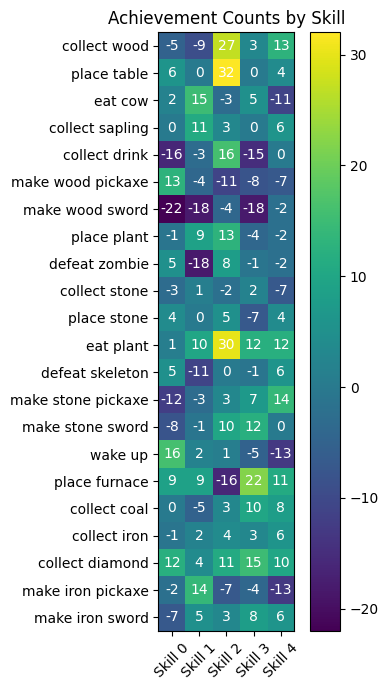

In [2]:
import matplotlib.pyplot as plt

skill_size = 5
skill_labels = [f'Skill {i}' for i in range(skill_size)]
achievement_labels = ['collect wood', 'place table', 'eat cow', 'collect sapling', 'collect drink', 'make wood pickaxe', 'make wood sword', 'place plant', 'defeat zombie', 'collect stone', 'place stone', 'eat plant', 'defeat skeleton', 'make stone pickaxe', 'make stone sword', 'wake up', 'place furnace', 'collect coal', 'collect iron', 'collect diamond', 'make iron pickaxe', 'make iron sword']
achivement_counts = jax.random.normal(key=jax.random.PRNGKey(0), shape=(skill_size, 22)) * 10 + 3.0
achivement_counts = achivement_counts.astype(int)

plt.figure(figsize=(4, 7))
plt.imshow(achivement_counts.T)
plt.xticks(range(skill_size), skill_labels, rotation=45)
plt.yticks(range(22), achievement_labels)
plt.title('Achievement Counts by Skill')
plt.tight_layout()
plt.colorbar()

for i in range(22):
    for j in range(skill_size):
        text = plt.text(j, i, round(achivement_counts[j, i], 1),
                       ha="center", va="center", color="w")

plt.show()

In [20]:
from models import QNetCraftax, Discriminator
from ml_collections import ConfigDict
from craftax_classic.envs.craftax_symbolic_env import CraftaxClassicSymbolicEnv
from craftax_classic.renderer import render_craftax_pixels
from environment_base.wrappers import BatchEnvWrapper
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageSequence
import IPython
import numpy as np
from tqdm import tqdm
import wandb

from crafter_constants import action_names
from crafter_utils import embedding_crafter, new_embedding_model

config = ConfigDict({
    'state_size': 1345,
    'skill_size': 5,
    'embedding_size': 1345,
    'action_size': 17,
    'policy_units': 1024,
    'discrim_units': 1024,
    'dropout_rate': 0.2
})

qlocal_key = jax.random.PRNGKey(0)
discrim_key = jax.random.PRNGKey(1)
dummy_state = jnp.zeros((1, config.state_size))
dummy_embedding = jnp.zeros((1, config.embedding_size))
dummy_skill = jnp.zeros((1, config.skill_size))

qlocal = QNetCraftax(
    action_size=config.action_size,
    hidden1_size=config.policy_units,
    hidden2_size=config.policy_units
)
qlocal_params = qlocal.init(qlocal_key, dummy_state, dummy_skill)

discrim = Discriminator(
    skill_size=config.skill_size,
    hidden1_size=config.discrim_units,
    hidden2_size=config.discrim_units
)
discrim_params = discrim.init(discrim_key, dummy_embedding)

In [21]:
env = CraftaxClassicSymbolicEnv()
env_params = env.default_params

In [23]:
key = random.PRNGKey(0)

def gather_rollouts(key, embedding_fn, skill_size, num_rollouts=5, max_steps_per_rollout=500):
    skill_rollouts = []
    for skill_idx in range(skill_size):
        skill = jax.nn.one_hot(skill_idx, config.skill_size)
        rollouts = []
        for _ in tqdm(range(num_rollouts)):
            key, env_init_key = random.split(key, num=2)
            obs, state = env.reset(env_init_key, env_params)

            rollout = []
            for t in tqdm(range(max_steps_per_rollout), leave=False):
                key, env_step_key = random.split(key, num=2)
                
                qvalues = qlocal.apply(qlocal_params, obs.reshape(1, -1), skill.reshape(1, -1))
                action_probs = jax.nn.softmax(qvalues)[0]
                action = jnp.argmax(qvalues, axis=-1).item()

                next_obs, next_state, reward, done, info = env.step(env_step_key, state, action, env_params)
                next_obs_embedding, next_obs_sentence = embedding_fn(next_obs.reshape(1, -1))
                print(next_obs_sentence)
                discrim_logits = discrim.apply(discrim_params, next_obs_embedding.reshape(1, -1))
                discrim_probs = jax.nn.softmax(discrim_logits)[0]

                frame = render_craftax_pixels(state, 64) / 255.0
                img = Image.fromarray(np.uint8(frame * 255)).convert('RGB')

                action_name = action_names[action]
                action_prob = round(action_probs[action].item(), 4)
                discrim_prob = round(discrim_probs[skill_idx].item(), 4)

                draw = ImageDraw.Draw(img)
                draw.text((10, 410), "t=1", (255, 255, 255), font_size=24, stroke_width=1)
                draw.text((10, 10), f"Action: {action_name}", (255, 255, 255), font_size=24, stroke_width=1)
                draw.text((10, 40), f"Action Prob: {action_prob}", (255, 255, 255), font_size=24, stroke_width=1)
                draw.text((300, 10), f"Skill {skill_idx} Prob: {discrim_prob}", (255, 255, 255), font_size=24, stroke_width=1)

                rollout.append(np.array(img))

                obs, state = next_obs, next_state
                if done:
                    break

            rollout_tensor = np.array(rollout).transpose(0, 3, 1, 2)
            rollouts.append(rollout_tensor)
        skill_rollouts.append(rollouts)
    return skill_rollouts


rollouts = gather_rollouts(random.PRNGKey(0), lambda x: (x, None), 1, num_rollouts=1, max_steps_per_rollout=500)

  0%|          | 0/1 [00:00<?, ?it/s]

None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None


None
None
None
None


None
None
None
None


None
None
None
None
None


100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


None


  0%|          | 0/1 [00:00<?, ?it/s]

None
None
None
None
None


None
None
None


None
None


None
None
None


None
None


None
None
None
None
None


None
None
None


None
None


None
None
None


None
None


None
None
None
None
None


None
None


None
None
None


None
None


None
None
None
None


None
None
None


None


None
None
None


None


None
None
None


None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


None
None
None
None


  0%|          | 0/1 [00:00<?, ?it/s]

None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


None
None
None
None
None


100%|██████████| 1/1 [00:04<00:00,  4.36s/it]

None
None
None
None


100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


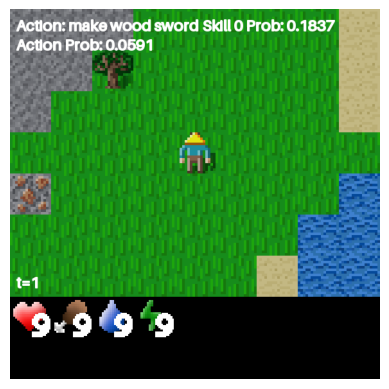

In [25]:
img = rollouts[0][0][0].transpose(1, 2, 0)

plt.figure()
plt.imshow(np.array(img))
plt.axis('off')
plt.axis("tight")
plt.axis("image")
plt.show()

In [17]:
rollouts[2][0].shape

(93, 3, 576, 576)

In [19]:
key = jax.random.PRNGKey(37)
key, e_key, si_key = jax.random.split(key, num=3)

embeddings = jax.random.normal(key=e_key, shape=(10000, 30))
skill_idxs = jax.random.randint(key=si_key, shape=(10000,), minval=0, maxval=5)
timestep_bins = jax.random.randint(key, shape=(10000,), minval=0, maxval=10, dtype=jnp.int32)
skills = jax.nn.one_hot(skill_idxs, 5)

print(embeddings.shape, skills.shape, timestep_bins.shape)

(10000, 30) (10000, 5) (10000,)


In [20]:
from jax import vmap

def separate_features(features, idxs):
    i = jnp.argsort(idxs)
    sorted_features = features[i]
    sorted_idxs = idxs[i]

    changes = jnp.where(jnp.diff(sorted_idxs) != 0)[0] + 1
    grouped_features = jnp.split(sorted_features, changes)
    grouped_idxs = jnp.split(sorted_idxs, changes)
    return grouped_features, grouped_idxs

def obs_to_features(obs):
    maps, metadata = jnp.split(obs, [7 * 9 * 21], axis=1)
    
    maps = jnp.reshape(maps, [-1, 7, 9, 21])
    maps = jnp.transpose(maps, [0, 3, 1, 2])
    maps = jnp.reshape(maps, [-1, 21, 7 * 9])
    maps = maps.sum(axis=2)

    features = jnp.concatenate((maps, metadata), axis=-1)
    return features

def compute_feature_divergence(features, skills):
    def kl_divergence(mu1, sigma1, mu2, sigma2):
        return jnp.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5
    
    def average_divergence(means, stds):
        n = len(means)
        kl_matrix = jnp.zeros((n, n))

        def pairwise_kl(i, j):
            return kl_divergence(means[i], stds[i], means[j], stds[j])

        kl_matrix = vmap(pairwise_kl, (0, None))(jnp.arange(n), jnp.arange(n))
        avg_div = jnp.mean(kl_matrix)
        return avg_div

    grouped_features, _ = separate_features(features, jnp.argmax(skills, axis=1))

    all_means = []
    all_stds = []
    for i in range(len(grouped_features)):
        feature_means = jnp.mean(grouped_features[i], axis=0)
        feature_stds = jnp.std(grouped_features[i], axis=0)

        all_means.append(feature_means)
        all_stds.append(feature_stds)
    all_means = jnp.nan_to_num(jnp.array(all_means), nan=0)
    all_stds = jnp.nan_to_num(jnp.array(all_stds), nan=1)

    avg_divs = vmap(lambda i: average_divergence(all_means[:, i], all_stds[:, i]))(jnp.arange(features.shape[1]))
    return avg_divs

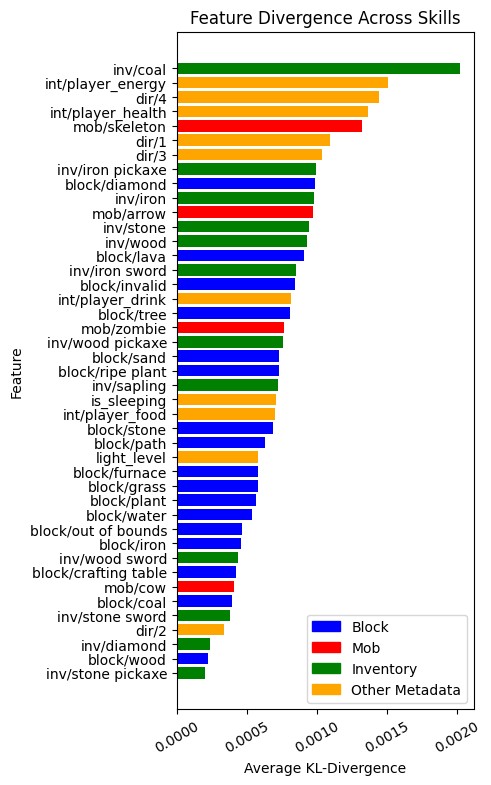

In [31]:
from crafter_constants import *

key, f_key = jax.random.split(key)
features = obs_to_features(jax.random.normal(key=f_key, shape=(10000, (7 * 9 * 21) + 22)))
avg_divs = compute_feature_divergence(features, skills).tolist()
colors = ['blue'] * 17 + ['red'] * 4 + ['green'] * 12 + ['orange'] * 10

pairs = zip(feature_names, avg_divs, colors)
pairs = sorted(pairs, key=lambda x: x[1])
sorted_feature_names, avg_divs, colors = zip(*pairs)

# Plot horizontal bar graph
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(5, 8))
plt.barh(y=sorted_feature_names, width=avg_divs, color=colors)
plt.xticks(rotation=30)
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.title('Feature Divergence Across Skills')
plt.xlabel('Average KL-Divergence')
plt.ylabel('Feature')
plt.legend(handles=[mpatches.Patch(color='blue', label='Block'),
                    mpatches.Patch(color='red', label='Mob'),
                    mpatches.Patch(color='green', label='Inventory'),
                    mpatches.Patch(color='orange', label='Other Metadata')])

plt.tight_layout()
plt.show()

In [32]:
from sklearn.manifold import TSNE
# grouped_features, grouped_skill_idxs, grouped_timestep_bins = separate_features(features, skills)

# # Concatenate all grouped_features
# all_grouped_features = jnp.concatenate(grouped_features, axis=0)
# print(all_grouped_features.shape)

# all_grouped_skill_idxs = jnp.concatenate(grouped_skill_idxs, axis=0)
# print(all_grouped_skill_idxs.shape)
print(features.shape)

(10000, 43)


In [33]:
features_embedded = TSNE(verbose=1).fit_transform(features)
print(features_embedded.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 6.421s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 10.097678
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.680061
[t-SNE] KL divergence after 1000 iterations: 4.234806
(10000, 2)


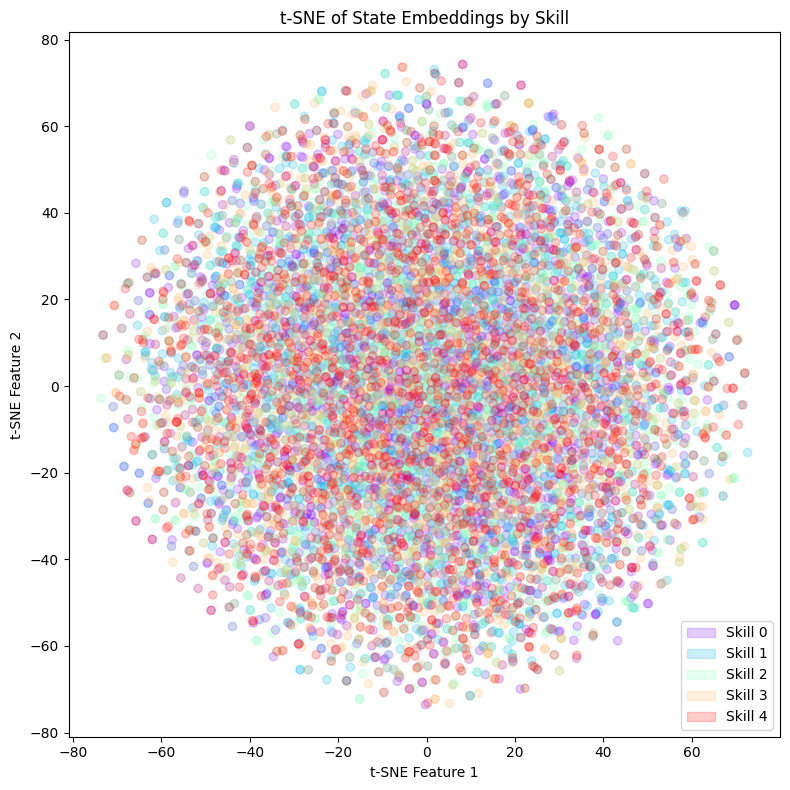

In [61]:
import matplotlib as mpl
import numpy as onp

def plot_embeddings_by_skill(features_embedded, skill_idxs, skill_size):
    grouped_features, grouped_skill_idxs = separate_features(features_embedded, skill_idxs)
    grouped_features = jnp.concatenate(grouped_features, axis=0)
    grouped_skill_idxs = jnp.concatenate(grouped_skill_idxs, axis=0)
    
    cmap = mpl.colormaps['rainbow']
    colors = jnp.array(cmap(onp.linspace(0, 1, skill_size)))
    colors = colors.at[:, -1].set(0.2)
    color_assignments = colors[grouped_skill_idxs]

    plt.figure(figsize=(8, 8))
    plt.scatter(features_embedded[:, 0], features_embedded[:, 1], c=color_assignments)
    plt.title('t-SNE of State Embeddings by Skill')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.tight_layout()

    handles = [mpatches.Patch(color=onp.array(colors[i]), label=f'Skill {i}') for i in range(skill_size)]
    plt.legend(handles=handles, loc='lower right')

plot_embeddings_by_skill(features_embedded, jnp.argmax(skills, axis=1), 5)

In [56]:
timesteps = jax.random.randint(key, shape=(10000,), minval=0, maxval=300, dtype=jnp.int32)

def bin_timesteps(timesteps):
    bins = jnp.empty_like(timesteps, dtype=jnp.int32)
    bins = bins.at[(timesteps < 50)].set(0)
    bins = bins.at[(timesteps >= 50) & (timesteps < 100)].set(1)
    bins = bins.at[(timesteps >= 100) & (timesteps < 150)].set(2)
    bins = bins.at[(timesteps >= 150) & (timesteps < 200)].set(3)
    bins = bins.at[(timesteps >= 200) & (timesteps < 250)].set(4)
    bins = bins.at[(timesteps >= 250) & (timesteps < 300)].set(5)
    bins = bins.at[(timesteps >= 300) & (timesteps < 400)].set(6)
    bins = bins.at[(timesteps >= 400)].set(7)
    return bins

timestep_bins = bin_timesteps(timesteps)
print(timesteps)
print(timestep_bins)

[ 47  87 278 ... 162 239 276]
[0 1 5 ... 3 4 5]


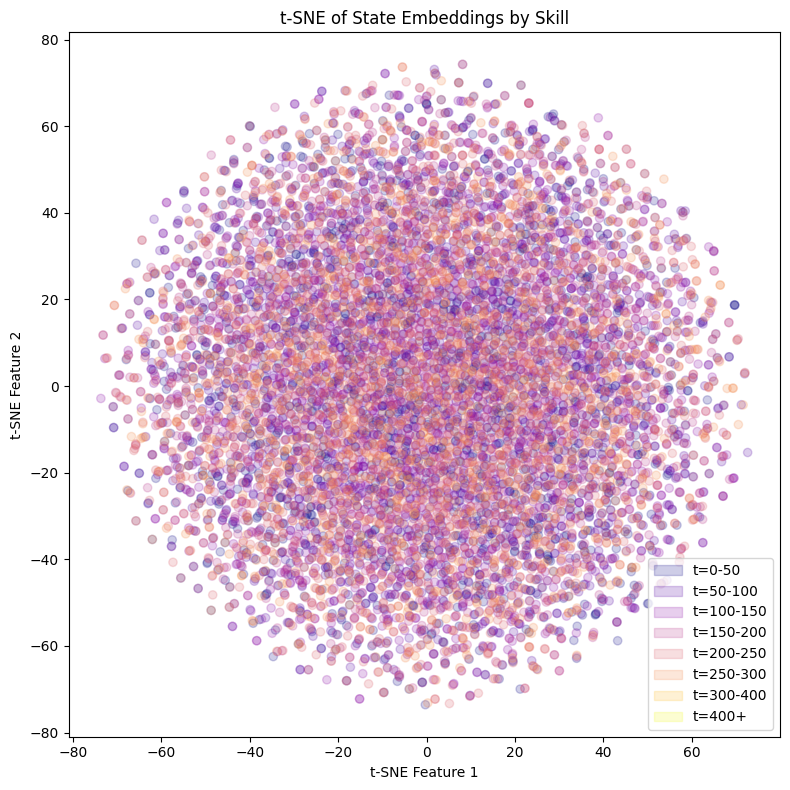

In [59]:
def plot_embeddings_by_timestep(features_embedded, timesteps):
    timestep_bins = bin_timesteps(timesteps)
    grouped_features, grouped_bins = separate_features(features_embedded, timestep_bins)
    grouped_features = jnp.concatenate(grouped_features, axis=0)
    grouped_bins = jnp.concatenate(grouped_bins, axis=0)
    
    cmap = mpl.colormaps['plasma']
    colors = jnp.array(cmap(onp.linspace(0, 1, 8)))
    colors = colors.at[:, -1].set(0.2)
    color_assignments = colors[grouped_bins]

    plt.figure(figsize=(8, 8))
    plt.scatter(features_embedded[:, 0], features_embedded[:, 1], c=color_assignments)
    plt.title('t-SNE of State Embeddings by Timestep')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.tight_layout()

    handles = [mpatches.Patch(color=onp.array(colors[0]), label=f't=0-50'),
               mpatches.Patch(color=onp.array(colors[1]), label=f't=50-100'),
               mpatches.Patch(color=onp.array(colors[2]), label=f't=100-150'),
               mpatches.Patch(color=onp.array(colors[3]), label=f't=150-200'),
               mpatches.Patch(color=onp.array(colors[4]), label=f't=200-250'),
               mpatches.Patch(color=onp.array(colors[5]), label=f't=250-300'),
               mpatches.Patch(color=onp.array(colors[6]), label=f't=300-400'),
               mpatches.Patch(color=onp.array(colors[7]), label=f't=400+')]
    plt.legend(handles=handles, loc='lower right')

plot_embeddings_by_timestep(features_embedded, timesteps)

In [17]:
import numpy as np
from flax import linen as nn
from jax import tree_util

def get_size(data) -> int:
    sizes = tree_util.tree_map(lambda arr: len(arr), data)
    return max(tree_util.tree_leaves(sizes))

class Dataset(flax.core.FrozenDict):
    """
    A class for storing (and retrieving batches of) data in nested dictionary format.

    Example:
        dataset = Dataset({
            'observations': {
                'image': np.random.randn(100, 28, 28, 1),
                'state': np.random.randn(100, 4),
            },
            'actions': np.random.randn(100, 2),
        })

        batch = dataset.sample(32)
        # Batch will have nested shape: {
        # 'observations': {'image': (32, 28, 28, 1), 'state': (32, 4)},
        # 'actions': (32, 2)
        # }
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.size = get_size(self._dict)

    def sample(self, batch_size: int, indx=None):
        """
        Sample a batch of data from the dataset. Use `indx` to specify a specific
        set of indices to retrieve. Otherwise, a random sample will be drawn.

        Returns a dictionary with the same structure as the original dataset.
        """
        if indx is None:
            indx = np.random.randint(self.size, size=batch_size)
        return self.get_subset(indx)

    def get_subset(self, indx):
        return tree_util.tree_map(lambda arr: arr[indx], self._dict)

class ReplayBuffer(Dataset):
    """
    Dataset where data is added to the buffer.

    Example:
        example_transition = {
            'observations': {
                'image': np.random.randn(28, 28, 1),
                'state': np.random.randn(4),
            },
            'actions': np.random.randn(2),
        }
        buffer = ReplayBuffer.create(example_transition, size=1000)
        buffer.add_transition(example_transition)
        batch = buffer.sample(32)

    """

    @classmethod
    def create(cls, transition, size: int):
        def create_buffer(example):
            example = np.array(example)
            return np.zeros((size, *example.shape), dtype=example.dtype)

        buffer_dict = tree_util.tree_map(create_buffer, transition)
        return cls(buffer_dict)

    @classmethod
    def create_from_initial_dataset(cls, init_dataset: dict, size: int):
        def create_buffer(init_buffer):
            buffer = np.zeros((size, *init_buffer.shape[1:]), dtype=init_buffer.dtype)
            buffer[: len(init_buffer)] = init_buffer
            return buffer

        buffer_dict = tree_util.tree_map(create_buffer, init_dataset)
        dataset = cls(buffer_dict)
        dataset.size = dataset.pointer = get_size(init_dataset)
        return dataset

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.max_size = get_size(self._dict)
        self.size = 0
        self.pointer = 0

    def add_transition(self, transition):
        def set_idx(buffer, new_element):
            buffer[self.pointer] = new_element

        tree_util.tree_map(set_idx, self._dict, transition)
        self.pointer = (self.pointer + 1) % self.max_size
        self.size = max(self.pointer, self.size)

In [19]:
example_transition = {
    'observations': {
        'image': np.random.randn(28, 28, 1),
        'state': np.random.randn(4),
    },
    'actions': np.random.randn(2),
}
buffer = ReplayBuffer.create(example_transition, size=1000)
buffer.add_transition(example_transition)
batch = buffer.sample(32)